The chest-x-ray image dataset consists of images categorized into four distinct classes: pneumonia, tuberculosis, covid and normal. Each class represents chest xray images of patients diagnosed with the respective condition or healthy individuals for the normal class. The dataset is intended to support research in medical image analysis, particularly for the automated detection and classification of respiratory diseases using machine learning and deep learning techniques

In [1]:
#Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
random.seed(101) #fix random seed
import os

#libraries for opencv
import cv2
%pip install imutils
import imutils

#libraries for scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

#libraries for tensorflow
import tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pritpal2873/chest-x-ray-dataset-4-categories")

print("Path to dataset files:", path)

100%|██████████| 1.74G/1.74G [00:47<00:00, 39.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1


In [3]:
import os

path = "/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1"
folders = os.listdir(path)

print("Conteúdo do dataset:", folders)

for root, dirs, files in os.walk(path):
    print(f"\nDiretório: {root}")
    print("Subpastas:", dirs)




Conteúdo do dataset: ['Chest X_Ray Dataset']

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1
Subpastas: ['Chest X_Ray Dataset']

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset
Subpastas: ['TURBERCULOSIS', 'COVID19', 'NORMAL', 'PNEUMONIA']

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/TURBERCULOSIS
Subpastas: []

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/COVID19
Subpastas: []

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/NORMAL
Subpastas: []

Diretório: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/PNEUMONIA
Subpastas: []


In [4]:
import os
import cv2

Data_DIR = "/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset"

# Class labels
clinical_labels = ["PNEUMONIA", "NORMAL", "COVID19", "TURBERCULOSIS"]

# Lista de imagens e rótulos
X_Images = []
Y_Labels = []

# Variáveis para altura, largura e pixels
max_width = float('-inf')
min_width = float('inf')
max_height = float('-inf')
min_height = float('inf')

max_pixel = float('-inf')
min_pixel = float('inf')

for lab in clinical_labels:
    #folder path
    if lab == "TUBERCULOSIS": #due to spelling mistakes at kagle input folder directory
      folder_path = os.path.join(Data_DIR, "TUBERCULOSIS")

    else:
      folder_path = os.path.join(Data_DIR, lab)

    for img in os.listdir(folder_path):
      #image path
      img_path = os.path.join(folder_path, img)
      #read image
      image = cv2.imread(img_path)
      image = cv2.resize(image, (128, 128)) #reshaping
      if img is not None:
        #update min, max pixels
        max_pixel = max(max_pixel, image.max())
        min_pixel = min(min_pixel, image.min())

        #update height and width
        max_height = max(max_height, image.shape[0])
        min_height = min(min_height, image.shape[0])

        max_width = max(max_width, image.shape[1])
        min_width = min(min_width, image.shape[1])

        #update image and label list
        X_Images.append(image)
        Y_Labels.append(lab)
      else:
        print("invalid image")

print("Dat  has been loaded")



Dat  has been loaded


In [5]:
#print the pixels information
print(f"Maximum pixel value: {max_pixel}")
print(f"Minimum pixel value: {min_pixel}")

#print the image height and width informations
print(f"Maximum height value: {max_height}")
print(f"Minimum height value: {min_height}")

print(f"maximum width value: {max_width}")
print(f"minimum width value: {min_width}")

Maximum pixel value: 255
Minimum pixel value: 0
Maximum height value: 128
Minimum height value: 128
maximum width value: 128
minimum width value: 128


In [6]:
#Total number of sample
num_sample= len(X_Images)
print(f"Total number of sample is: {num_sample}")

Total number of sample is: 7132


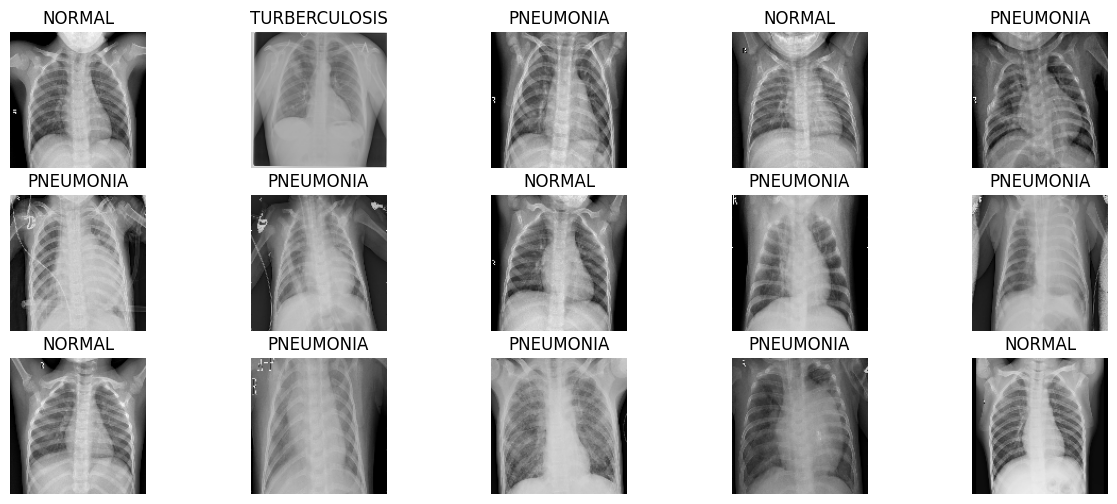

In [7]:
#visualize some raw images:
num_img= 15
#plot size
plt.figure(figsize=(15, 6))

#random sample
random_idx = random.sample(range(num_sample), num_img)
for i in range(num_img):
  plt.subplot(num_img // 5,5, i + 1) #3 rows and 5 columns
  plt.imshow(X_Images[random_idx[i]], cmap='gray')
  plt.axis('off')
  plt.title(f"{Y_Labels[random_idx[i]]}")

plt.show()

#Image Pre-Processing:

White Balance Approach:

white balance plays a crucial role in medical imaging, especially when analyzing chest X-rays (CRXR) for the diagnosis of viral infections like covid, pneumonia etc. In medical imaging, the goal is often to make the key features of the image (such as the lungs and surrounding tissues) clearly distinguishable from the rest of the image.

- Lungs: Typically appear black(or very dark) on chest X-rays becausa they are air-filled and absorb fewer x-rays compared to the surrounding tissues, such as bones and muscles. The dark areas represent low-density structures, which is important for visualizing the lungs in a chest X-ray.

- Bones, organs, and tissues, on the other hand, appear white or light gray becausa they absorb more x-rays, leading to a higher density in the image

We will apply white balance to improve the visuality of lungs:

In [8]:
#white balance for each channel
def WB_channel(channel, perc=0.05):
  mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100-perc))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))

  return channel

#white balance to an image
def WB_image(img):
  img = img.copy()
  imwb = np.dstack([WB_channel(channel, 0.05) for channel in cv2.split(img)]) #this is color wb image
  imwb_gray = cv2.cvtColor(imwb, cv2.COLOR_BGR2GRAY) #as original image in bgr format
  #return gray and color image

  return imwb_gray, imwb

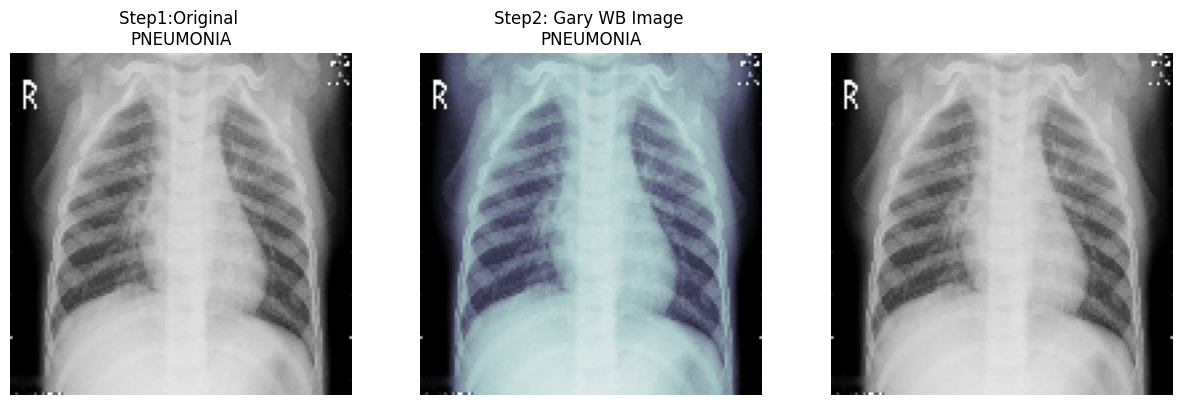

In [9]:
img = X_Images[0]
imgwb_gray, imwb_BGR = WB_image(img)
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(img, cmap = 'bone')
plt.title(f"Step1:Original \n{Y_Labels[0]}")
plt.axis('off')
plt.subplot(132)
plt.imshow(imgwb_gray, cmap='bone')
plt.title(f"Step2: Gary WB Image \n{Y_Labels[0]}")
plt.axis('off')
plt.subplot(133)
plt.imshow(imwb_BGR, cmap = 'bone')
plt.axis('off')
plt.show()

In [10]:
#we have visualized the white balance filtered image in both gary and bgr format.
#during dl model, we will proceed with BGR format to preserve all important
#features along the channels

In [11]:
image = cv2.resize(image, (128, 128))  # Reduzindo para 128x128


In [12]:
X_Images[0].shape

(128, 128, 3)

In [13]:
#Apply white balance on all the images
X_imwb = []
for img in X_Images:
  #apply WB on img
  _, imwb_BGR = WB_image(img) #only hold BGR format
  X_imwb.append(imwb_BGR)

print("WB has applied")

WB has applied


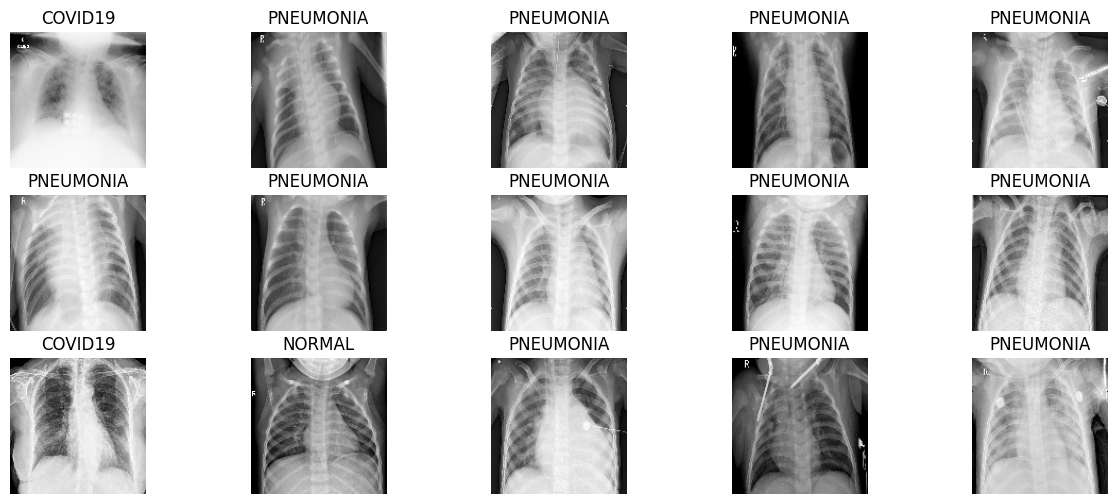

In [14]:
#Visualize WB images
#number of images
num_img = 15

#plot size
plt.figure(figsize=(15, 6))

#random sample
random_idx = random.sample(range(num_sample), num_img)
for i in range(num_img):
  plt.subplot(num_img // 5,5, i+1) #3 rows and 5 columns
  plt.imshow(X_imwb[random_idx[i]], cmap='gray')
  plt.axis('off')
  plt.title(f"{Y_Labels[random_idx[i]]}")

plt.show()

#Normalize the images:


In [15]:
X_imwb_norm = []
for img in X_imwb:
  img_norm = (img/255.0).astype('float32') #range of each pixels in each image becomes[0,1]
  X_imwb_norm.append(img_norm)

print('Normalized has done')

Normalized has done


Deep learning models often work better when the input data (in this case, pixel values) is within a specific range, typically between 0 and 1

- Faster convergence: Normalization can help the model learn faster and more efficiently;

#Class Distribution


In [16]:
#Convert all the list into np array
X_imwb_norm = np.array(X_imwb_norm)
Y_labels= np.array(Y_Labels)

In [17]:
#Counts for each types of tumor:
pd.DataFrame(list(Counter(Y_labels).items()), columns = ['Class', 'Count'])

,Class,Count
0,PNEUMONIA,4273
1,NORMAL,1583
2,COVID19,576
3,TURBERCULOSIS,700


<ipython-input-18-83f9b46db15a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=Y_labels, palette='viridis') #use dataframe with hue


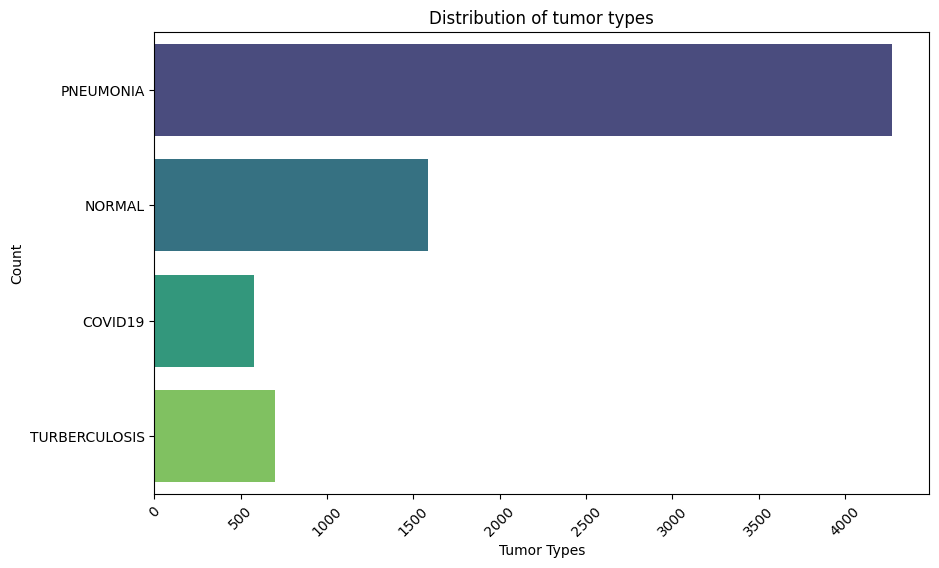

In [18]:
#plot using seaborn's countplot with 'viridis' pallet
plt.figure(figsize=(10,6))
sns.countplot(y=Y_labels, palette='viridis') #use dataframe with hue
plt.xticks(rotation = 45) #Rotate x-axis labels for better readability if needed
plt.xlabel('Tumor Types') #Label for the x-axis
plt.ylabel('Count')
plt.title('Distribution of tumor types')
plt.show()

clearly we have imbalanced dataset. We need to handle it carefully for robust and better generalize DL&AI predictor model.

#Splits the entire dataset into train and test randomly using stratified splitting:

Stratified splitting ensure that the class distribution in our dataset is preserved across training and test sets. This is particularly important for imbalanced datasets to prevent over-representation or under-representation of certain classes during model evaluation.

The split is performed based on the labels (target variable) to that the proportion of each class in the original dataset is reflected in both the train and test sets. In python, this can be implemented using stratify in train_test_split from sklearn. It is especially useful in classification problems where maintaining class balance is crucial.

In [19]:
#stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X_imwb_norm, Y_labels, test_size=0.2, stratify=Y_labels, random_state=42)

print('spliting into 80-20 has done')

spliting into 80-20 has done


,Class,Count
0,PNEUMONIA,3418
1,TURBERCULOSIS,560
2,NORMAL,1266
3,COVID19,461


<ipython-input-20-a34ab1594aed>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y= y_train, palette='viridis')


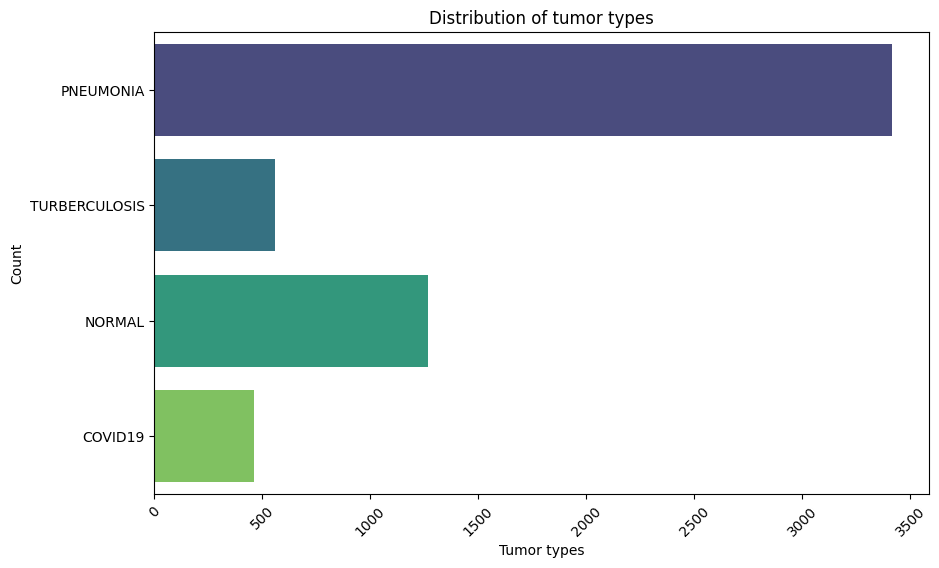

In [20]:
#Distribution of class in training set
display(pd.DataFrame(list(Counter( y_train).items()), columns = ['Class', 'Count']))

#Barplots
#plot using seaborn's countplot with 'viridis' palette
plt.figure(figsize=(10, 6))
sns.countplot(y= y_train, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Tumor types')
plt.ylabel('Count')
plt.title('Distribution of tumor types')
plt.show()

#convert categorical label into numeric values & one-hot representations:

In [21]:
label_encoder = LabelEncoder()

#fit or train set
y_train_encoded = label_encoder.fit_transform(y_train)

#transform on test set
y_test_encoded = label_encoder.transform(y_test)

In [22]:
#get the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping", label_mapping)

Label Mapping {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


In [23]:
#Integer label to one-hot conversion

y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))



In [24]:
print(f"Before encoding: {y_test}")
print(f"After encoding: {y_test_encoded}")
print(f"After one-hot representation: {y_test_one_hot}")

Before encoding: ['NORMAL' 'PNEUMONIA' 'PNEUMONIA' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']
After encoding: [1 2 2 ... 2 2 2]
After one-hot representation: [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [25]:
#Ensure all the sets have same formate
print('Train image:', type(X_train))
print('Train label:', type(y_train_one_hot))
print('Test image:', type(X_test))
print('Train label:', type(y_test_one_hot))

Train image: <class 'numpy.ndarray'>
Train label: <class 'numpy.ndarray'>
Test image: <class 'numpy.ndarray'>
Train label: <class 'numpy.ndarray'>


We have
- training set as: (X_train, y_train_one_hot)
- test set as: (X_test, y_test_one_hot)

#Model Building

In [26]:
#load base line model for feature extraction
#load the MobileNetV2 as base model with out top
base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape=(128, 128, 3))

#Freeze the base model layers
for layer in base_model.layers:
  layer.trainable= True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
#Define the custome dense layers on top:

#Custome top dense layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)  # Since our number of class is 4

In [28]:
#Create the final model
model = Model(inputs=base_model.input, outputs=output)

#Compiles the model
model.compile(optimizer=Adam(learning_rate=0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

#model.summary()

In [29]:
#Early stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.3, patience=2, min_lr=1e-10, verbose=1)

#Add modelCheckpoint to save the best model based on validation loss

model_checkpoint= ModelCheckpoint('Best_Model_On_Partial.keras', monitor= 'val_loss', save_best_only = True, mode= 'min', verbose=1)

if the val_loss doesn't improve for 5 consecutive epochs the training process is stopped early

- Train model on train set::
IMage generator:


In [30]:
#Data generator for training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range= 0.05,
    height_shift_range=0.05,
    fill_mode= 'nearest'
)
"""
this is a powerful tool for data augmentation, which is
a technique used to artificially increase the size of your training
dataset by creating modified versions of your existing images.
"""

'\nthis is a powerful tool for data augmentation, which is\na technique used to artificially increase the size of your training\ndataset by creating modified versions of your existing images.\n'

In [31]:
#fits the model on our dataset
history1 = model.fit(train_datagen.flow(X_train, y_train_one_hot),
                     epochs = 50,
                     batch_size= 32,
                     validation_data = (X_test, y_test_one_hot),
                     verbose=1,
                     callbacks=[early_stop, reduce_lr, model_checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5162 - loss: 1.2015
Epoch 1: val_loss improved from inf to 4.54448, saving model to Best_Model_On_Partial.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 320ms/step - accuracy: 0.5173 - loss: 1.1993 - val_accuracy: 0.0981 - val_loss: 4.5445 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9090 - loss: 0.3294
Epoch 2: val_loss improved from 4.54448 to 1.17558, saving model to Best_Model_On_Partial.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.9090 - loss: 0.3294 - val_accuracy: 0.7008 - val_loss: 1.1756 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9178 - loss: 0.2630
Epoch 3: val_loss did not improve from 1.17558
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.9178 - loss: 0.2629 - val_accuracy: 0.7015 - val_loss: 1.9171 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.

In [36]:
#PERFORMANCE METRICS
#Load trained model
Predicted_model = load_model('Best_Model_On_Partial.keras')
print(f"Trained model Best_Model.keras has loaded")

Trained model Best_Model.keras has loaded


In [37]:
#predictions on test set
batch_size = 16 #adjust batch size based on your gpu memory capacity
pred_lab_dist = []
for i in range(0, len(X_test), batch_size):
  batch = X_test[i:i+batch_size]
  batch_pred = Predicted_model.predict(batch, verbose=0)
  pred_lab_dist.append(batch_pred)

#Concatenate all batch predictions
pred_lab_dist = np.concatenate(pred_lab_dist, axis=0)

#true label
Y_true = y_test_encoded

#predicted label
Y_pred = np.argmax(pred_lab_dist, axis=-1)

#classification report
cls_rep = classification_report(Y_true, Y_pred)
print(f"Classification report: {cls_rep}")

#Confusion matrix
cnf_mtx = confusion_matrix(Y_true, Y_pred)
print(f"confusion matrix {cnf_mtx}")

Classification report:               precision    recall  f1-score   support

           0       0.99      0.92      0.95       115
           1       0.89      0.97      0.93       317
           2       0.99      0.96      0.97       855
           3       0.99      1.00      1.00       140

    accuracy                           0.96      1427
   macro avg       0.96      0.96      0.96      1427
weighted avg       0.97      0.96      0.96      1427

confusion matrix [[106   7   1   1]
 [  0 308   9   0]
 [  1  33 821   0]
 [  0   0   0 140]]


Accuracy & Loss plots:


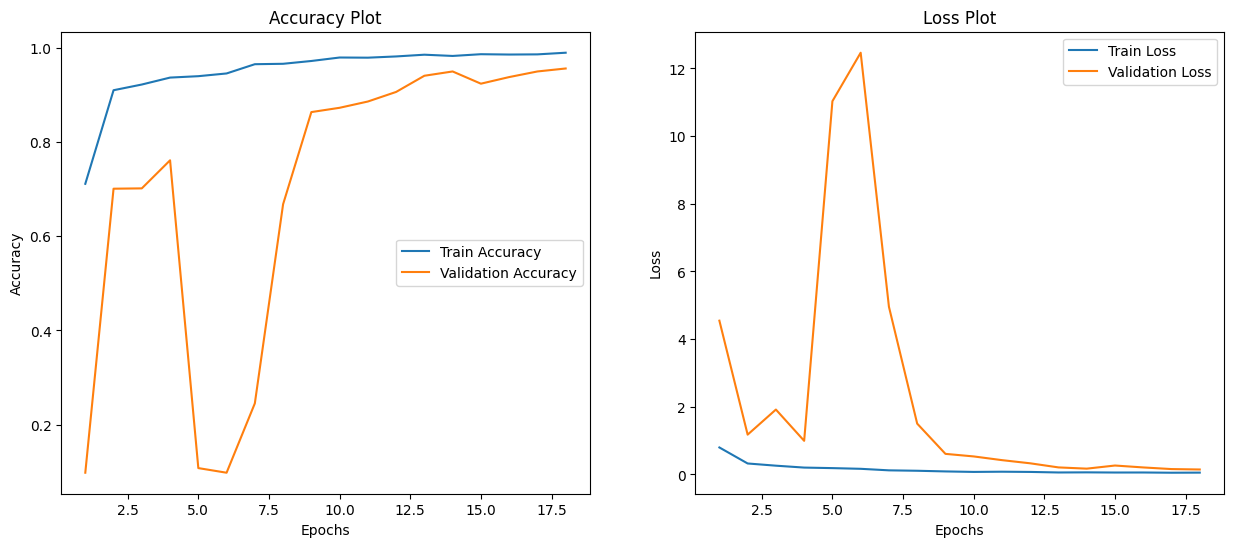

In [38]:
#figure size
plt.figure(figsize=(15, 6))
#training accuracy and validation accuracy
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epochs = range(1, 19) #as best performance at epoch 18
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc[:18], label = 'Train Accuracy')
plt.plot(epochs, val_acc[:18], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend(loc='center right')

#Training and validation losses
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss[:18], label = 'Train Loss')
plt.plot(epochs, val_loss[:18], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(loc='upper right')

plt.show()

<Axes: >

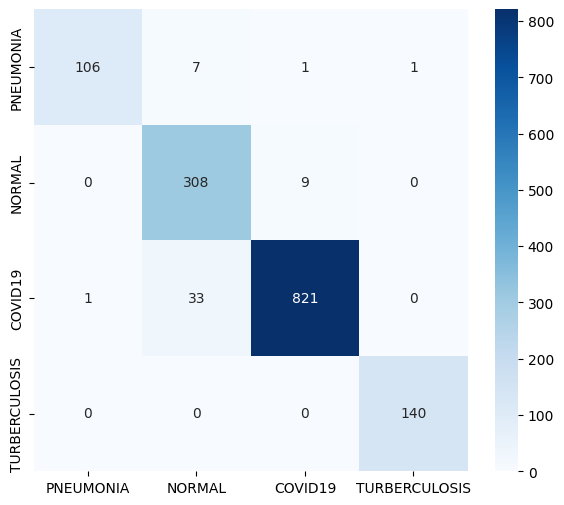

In [39]:
#Confusion matrix plot
plt.figure(figsize=(7, 6))
sns.heatmap(cnf_mtx, annot=True, fmt='d', cmap='Blues', xticklabels = clinical_labels, yticklabels=clinical_labels)


#Predicting viral infection on unseen Chest X-Ray:

- Image preprocessing:

In [40]:
#White balance for each channel
def WB_channel(channel, perc=0.05):
  mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100-perc))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
  return channel

#white balance to an image
def WB_image(img):
  img = img.copy()
  imwb = np.dstack([WB_channel(channel, 0.05) for channel in cv2.split(img)]) #this is color wb image
  imwb_gray = cv2.cvtColor(imwb, cv2.COLOR_BGR2GRAY) #as original image in bgr format
  #return gray and color image

  return imwb_gray, imwb

In [50]:
#Function to perform complete image processing
def Image_PreProcessing(img, wb=None, target_size=(128, 128)):
  img = img.copy()
  if wb is not None:
    _,img = wb(img)

  #resize
  img = cv2.resize(img, dsize=target_size)

  ##normaliz
  img = (img/255.0).astype('float32')

  #return processed image
  return img

In [51]:
#read images
img_dir = "/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset" #Corrected path to the image dataset

img_labels = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]

img_folders = [(os.path.join(img_dir, lab), lab) for lab in img_labels]

In [52]:
img_folders

[('/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/COVID19',
  'COVID19'),
 ('/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/NORMAL',
  'NORMAL'),
 ('/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/PNEUMONIA',
  'PNEUMONIA'),
 ('/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/TURBERCULOSIS',
  'TURBERCULOSIS')]

In [53]:
#Extract 5 images from each of types
images = [(os.listdir(img_folder)[:5], lab, img_folder) for img_folder, lab in img_folders]
print(images)

[(['COVID19(557).jpg', 'COVID19(556).jpg', 'COVID19(171).jpg', 'COVID19(222).jpg', 'COVID19(370).jpg'], 'COVID19', '/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/COVID19'), (['NORMAL2-IM-0705-0001.jpeg', 'NORMAL2-IM-1273-0001.jpeg', 'NORMAL2-IM-0689-0001.jpeg', 'NORMAL2-IM-1117-0001.jpeg', 'NORMAL2-IM-0690-0001.jpeg'], 'NORMAL', '/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/NORMAL'), (['person44_virus_94.jpeg', 'person19_bacteria_58.jpeg', 'person986_bacteria_2913.jpeg', 'person972_virus_1646.jpeg', 'person575_bacteria_2374.jpeg'], 'PNEUMONIA', '/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1/Chest X_Ray Dataset/PNEUMONIA'), (['Tuberculosis-304.png', 'Tuberculosis-574.png', 'Tuberculosis-104.png', 'Tuberculosis-387.png', 'Tuberculosis-124.png'], 'TURBERCULOSIS', '/root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-datas

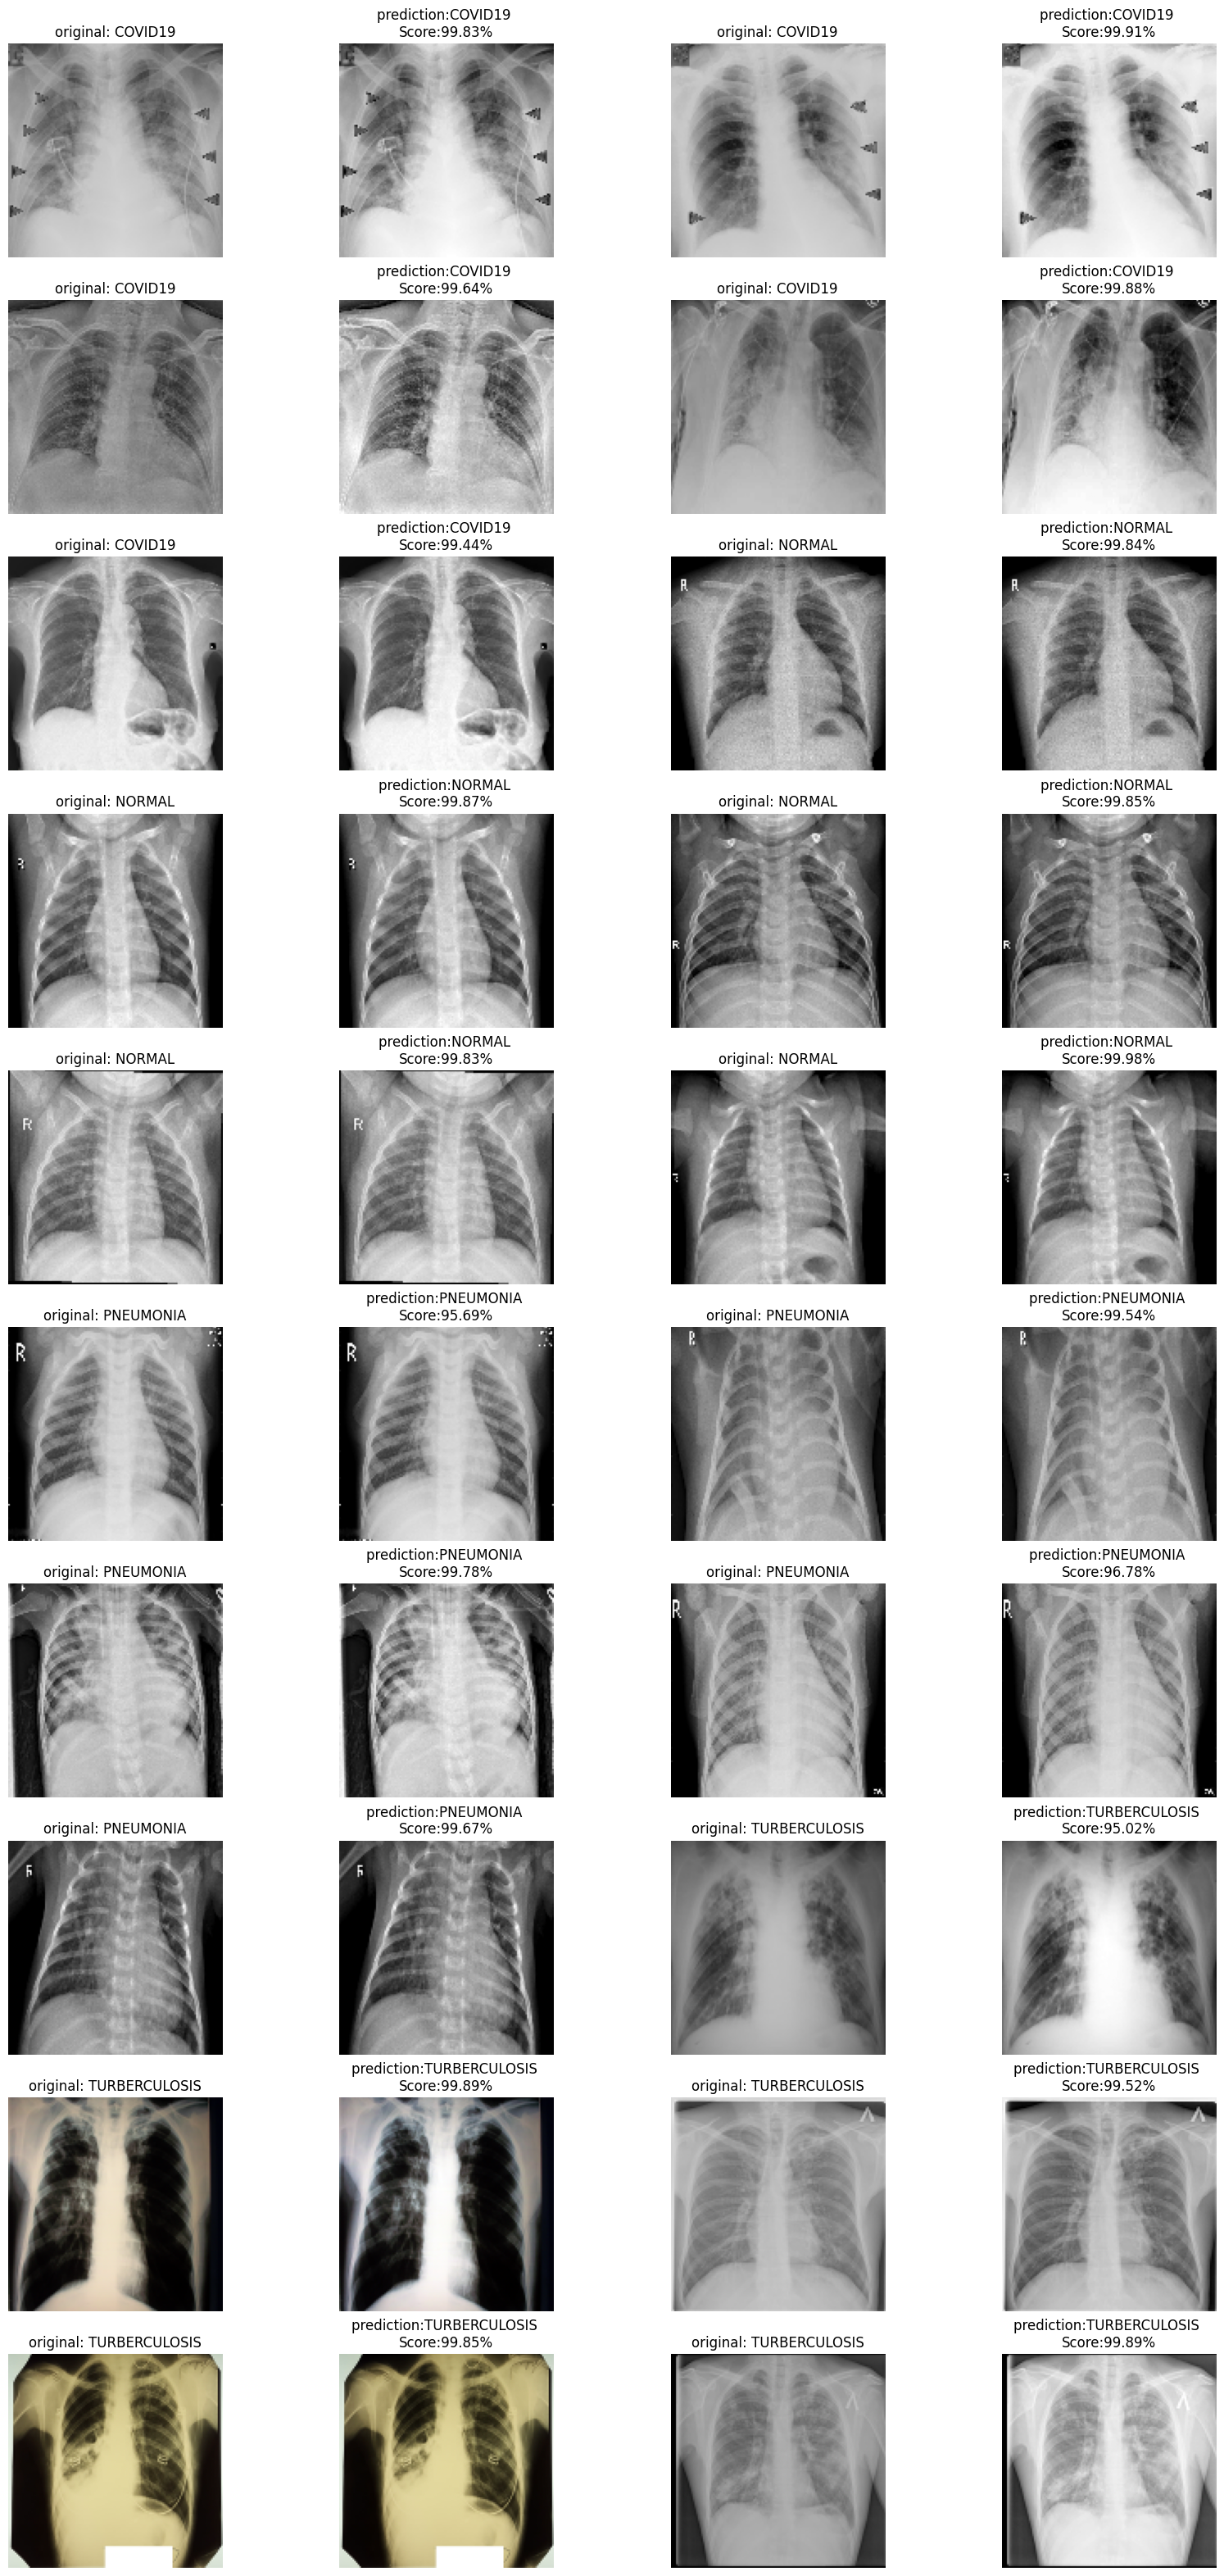

In [55]:
#predicts the viral types on each unseen data
#plot figure
#Calculate rows and columns dynamically
n_images = 5*len(images) * 2 #original + predicting
cols = 4
rows = (n_images + cols - 1) // cols #round up to fit all images
plt.figure(figsize=(20, rows * 4))
i = 1
for imgs, lab, folder in images:
  original_label = lab
  for img in imgs:
    #read image
    image_path = os.path.join(folder,img)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128)) #Resize to the expected input size

    #original image
    plt.subplot(rows, cols, i)
    plt.imshow(image, cmap='bone')
    plt.title(f"original: {original_label}")
    plt.axis('off')

    #predicted type with score on processed image
    image_pro = Image_PreProcessing(image,  wb=WB_image)

    #Dynamically reshapem, since target size is (128,128) 1 for batch size for single image
    target_shape= (1, *image_pro.shape)
    image_pro_re = image_pro.reshape(target_shape)
    predictions = Predicted_model.predict(image_pro_re, verbose=0)
    predicted_label = np.argmax(predictions, axis=-1)[0]
    predicted_score= np.max(predictions, axis=-1)[0]
    plt.subplot(rows, cols, i+1)
    plt.imshow(image_pro, cmap='bone')
    plt.title(f"prediction:{img_labels[predicted_label]} \nScore:{np.round(predicted_score*100,2)}%")
    plt.axis('off')
    i+=2
plt.show()